# Classificador

Análise de Formas 2s2023



Pietro Guarinello Cariola - nUSP 14194153



# Bibliotecas

In [ ]:
import gdown
import zipfile
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pathlib
from torchvision.transforms import v2
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import drive
import shutil

# Constantes

In [ ]:
URL_DATASET = 'https://drive.google.com/uc?id=1eL7GyBk07fInfwojAaGhSzGpKVDlKVb2'
DATASET_NAME = 'ep_shape_dataset'
PATH_DATASET = './ep_shape_dataset/dataset/'
TRAIN_SPLIT = 0.85
BATCH_SIZE = 4
NEW_SIZE = 128
LEARN_RATE = 1e-3
EPOCHS = 20
TEST_REPEAT = 5

# Dataset gerado pelo aplicativo

In [ ]:
class MyDataset(Dataset):
    def __init__(self, path_dataset, aug):
        super().__init__()
        self.path_dataset = path_dataset
        self.classes = []
        for path in pathlib.Path(path_dataset).glob("*/"):
            self.classes.append(path.name)
        self.class_number = {}
        for i, key in enumerate(self.classes):
            self.class_number[key] = i
        self.imgs = []
        for path in pathlib.Path(path_dataset).rglob("*.jpg"):
            self.imgs.append(path.name)
        self.aug = aug

    def __getitem__(self, i):
        x = Image.open(
            self.path_dataset +
            '/' + self.imgs[i].split('_')[0] + '/' +
            self.imgs[i]
        ).convert('L')
        x = np.array(x)
        aug = self.aug(image=x)
        x = aug['image']
        y = self.class_number[self.imgs[i].split('_')[0]]
        return x, y

    def __len__(self):
        return len(self.imgs)

In [ ]:
# download dataset
gdown.download(URL_DATASET, DATASET_NAME+'.zip', quiet=False)
with zipfile.ZipFile(DATASET_NAME+'.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_NAME)

Downloading...
From: https://drive.google.com/uc?id=1eL7GyBk07fInfwojAaGhSzGpKVDlKVb2
To: /content/ep_shape_dataset.zip
100%|██████████| 270M/270M [00:01<00:00, 236MB/s]


In [ ]:
# dataset
train_dataset = MyDataset(PATH_DATASET, A.Compose([
    A.ToFloat(),
    A.Resize(NEW_SIZE, NEW_SIZE),
    ToTensorV2()
]))
n1 = int(len(train_dataset) * TRAIN_SPLIT)
n2 = len(train_dataset) - n1
(train_data, val_data) = random_split(train_dataset, [n1, n2])

In [ ]:
# ensure both train and val have all the classes
train_classes = []
for i in range(len(train_data)):
    x, y = train_data[i]
    train_classes.append(train_dataset.classes[y])
train_classes = list(set(train_classes))
val_classes = []
for i in range(len(val_data)):
    x, y = val_data[i]
    val_classes.append(train_dataset.classes[y])
val_classes = list(set(val_classes))
train_classes.sort()
val_classes.sort()
print(f"Classes in training dataset: {train_classes}")
print(f"Classes in validation dataset: {val_classes}")
if train_classes != val_classes:
    print('WARNING: train and val dont have the same classes.')

Classes in training dataset: ['creme', 'faca', 'linha', 'relogio', 'tesoura']
Classes in validation dataset: ['creme', 'faca', 'linha', 'relogio', 'tesoura']


In [ ]:
# dataloader
train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, BATCH_SIZE)

# Visualizando o dataset

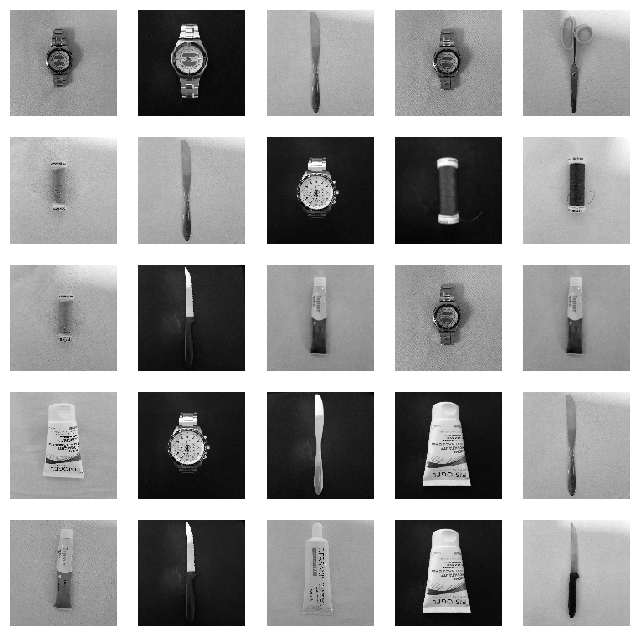

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(8,8))
idx = np.random.randint(len(train_dataset), size=(5, 5))
for i in range(5):
    for j in range(5):
        x, _ = train_dataset[idx[i,j]]
        ax[i,j].imshow(x[0,:,:], interpolation='none', cmap='gray')
        ax[i,j].axis('off')
plt.show()

# Modelo (CNN + FCs)

In [ ]:
class MyNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 5, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(5, 10, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(NEW_SIZE ** 2 * 10 // 4 // 4, 500),
            nn.Linear(500, n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Treinamento e validação

In [ ]:
def train(model, device, train_dataloader, val_dataloader, lr=LEARN_RATE,
          epochs=EPOCHS):
    # optimizer
    opt = torch.optim.Adam(model.parameters(), lr)

    # loss function
    loss_fn = nn.NLLLoss()

    # history
    hist = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'time': None
    }

    print('Starting training...')
    start_time = time.time()
    for epoch in range(epochs):
        print(f"EPOCH {epoch+1}/{epochs}")

        # training
        model.train()
        train_loss = 0
        train_hits = 0
        for (x, y) in train_dataloader:
            (x, y) = (x.to(device), y.to(device))
            x_hat = model(x)
            loss = loss_fn(x_hat, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss
            train_hits += (x_hat.argmax(1) == y).type(torch.float).sum()
        train_loss = train_loss / len(train_dataloader.dataset)
        train_accuracy = train_hits / len(train_dataloader.dataset)
        hist['train_loss'].append(train_loss.item())
        hist['train_accuracy'].append(train_accuracy.item())

        # validation
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_hits = 0
            for (x, y) in val_dataloader:
                (x, y) = (x.to(device), y.to(device))
                x_hat = model(x)
                loss = loss_fn(x_hat, y)
                val_loss += loss
                val_hits += (x_hat.argmax(1) == y).type(torch.float).sum()
            val_loss = val_loss / len(val_dataloader.dataset)
            val_accuracy = val_hits / len(val_dataloader.dataset)
            hist['val_loss'].append(val_loss.item())
            hist['val_accuracy'].append(val_accuracy.item())

    end_time = time.time()
    hist['time'] = end_time - start_time
    print(f'Training finished in {end_time - start_time:.0f}s.')
    return hist

In [ ]:
# free memory
torch.cuda.empty_cache()

# create model and send to device
model = MyNet(len(train_dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# train
hist = train(model, device, train_dataloader, val_dataloader)

# save model
torch.save(model.state_dict(), 'ep_shape_model.pth')

Starting training...
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20
Training finished in 176s.


# Loss chart

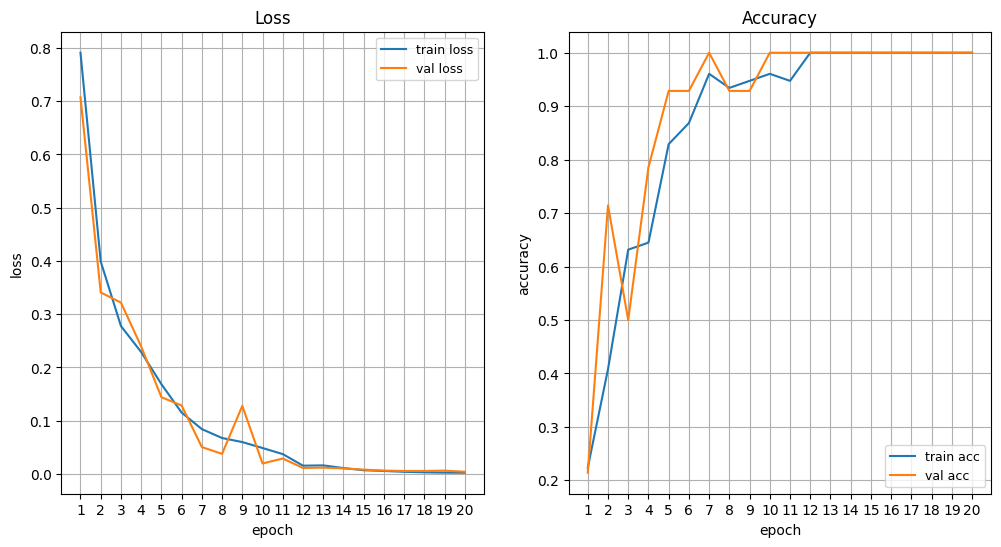

In [ ]:
# loss chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(1, EPOCHS + 1), hist['train_loss'], label='train loss')
ax[0].plot(np.arange(1, EPOCHS + 1), hist['val_loss'], label='val loss')
ax[0].set_title("Loss")
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(fontsize=9, loc='upper right')
ax[0].set_xticks(np.arange(1, EPOCHS + 1, 1))
ax[0].grid(True)

ax[1].plot(np.arange(1, EPOCHS + 1), hist['train_accuracy'], label='train acc')
ax[1].plot(np.arange(1, EPOCHS + 1), hist['val_accuracy'], label='val acc')
ax[1].set_title("Accuracy")
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(fontsize=9, loc='lower right')
ax[1].set_xticks(np.arange(1, EPOCHS + 1, 1))
ax[1].grid(True)

plt.show()

# Teste com dados aumentados

In [ ]:
def test(model, device, dataloader):
    print('Starting test...')
    y_true = []
    y_pred = []
    start_time = time.time()
    with torch.no_grad():
        model.eval()
        test_hits = 0
        for _ in range(TEST_REPEAT):
            for (x, y) in dataloader:
                (x, y) = (x.to(device), y.to(device))
                x_hat = model(x)
                y_pred.extend(x_hat.argmax(1).cpu().numpy())
                y_true.extend(y.cpu().numpy())
    end_time = time.time()
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    labels = dataloader.dataset.classes
    print(f'Test finished in {end_time - start_time:.0f}s.')
    print()
    print(classification_report(y_true, y_pred, target_names=labels))
    print()
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.show()

Starting test...
Test finished in 116s.

              precision    recall  f1-score   support

     tesoura       1.00      0.97      0.98        90
        faca       0.99      1.00      0.99        90
       linha       0.92      0.98      0.95        90
       creme       1.00      0.97      0.98        90
     relogio       0.97      0.96      0.96        90

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450




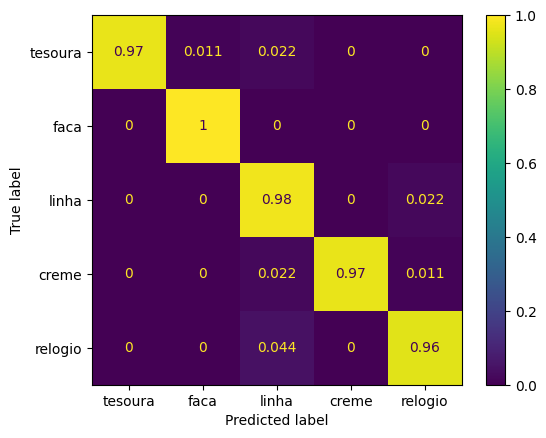

In [ ]:
# dataset
test_dataset = MyDataset(PATH_DATASET, A.Compose([
    A.ToFloat(),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0),
    A.ColorJitter(hue=0, p=1),
    A.Blur(p=1),
    A.Resize(NEW_SIZE, NEW_SIZE),
    ToTensorV2()
]))

# dataloader
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

# model
model = MyNet(len(test_dataset.classes))
model.to(device)
model.eval()
model.load_state_dict(torch.load('ep_shape_model.pth', map_location=device))

# free memory
torch.cuda.empty_cache()

# test
test(model, device, test_dataloader)

In [ ]:
# free model
del model
torch.cuda.empty_cache()

# Upload do modelo

In [ ]:
drive.mount('/content/drive')
shutil.copy("ep_shape_model.pth","/content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/ep_shape_model.pth'